## Hough lines using polar coordinates and by iterating through (voting for) rho and theta

### imports

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

### main variables

In [2]:
image_path = '../images/hey.png'

### functions

In [3]:
#Source: https://stackoverflow.com/a/42314798

def plotimage(img, title=None, figsize=None):
    h = img.shape[0]
    w = img.shape[1]
    dpi = 80
    if figsize is None:
        figsize = w / float(dpi), h / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])    
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()

### code

## Read Image

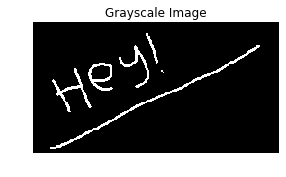

In [4]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
threshold = 100
gray[gray<threshold] = 0
gray[gray>=threshold] = 1
bw = 1-gray
plotimage(bw, 'Grayscale Image')

In [ ]:
# im2, contours, hierarchy = cv2.findContours(bw,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# contours_image = np.zeros_like(bw)
# cv2.drawContours(contours_image, contours, -1, 1)
# plotimage(contours_image)
# bw = contours_image

### Vote

In [5]:
def get_rho(theta, x, y):
    deg = np.deg2rad(theta)
    return x*np.cos(deg)+y*np.sin(deg)

In [6]:
def transform_coords(p1,p2):
    t0 = p1[0]
    t1 = p2[0]
    r0 = p1[1]
    r1 = p2[1]

    r0 = int((r0- rho_min)/rho_step)
    r1 = int((r1- rho_min)/rho_step)
    t0 = int((t0- theta_min)/theta_step)
    t1 = int((t1- theta_min)/theta_step)

    return (t0,r0), (t1,r1)

In [7]:
def draw_rho_theta(x,y):
    result_img = np.zeros((len(rho_axis), len(theta_axis)))

    rho = get_rho(theta_axis, x, y).astype('int')

    for i in range(len(theta_axis)-1):
        p1, p2 = transform_coords((theta_axis[i], rho[i]), (theta_axis[i+1], rho[i+1]))
        cv2.line(result_img, p1, p2, 1)

    return result_img

#### Voting

100.0%


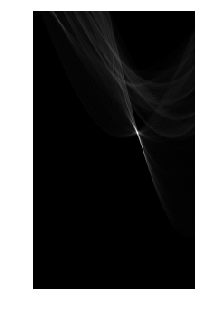

In [8]:
theta_min, theta_max = -89, 90
theta_step = 1
theta_axis = np.arange(theta_min, theta_max, theta_step).astype('int')

dist = int(np.linalg.norm(np.array(bw.shape)))
rho_min = 0
rho_max = dist
rho_step = 1
rho_axis = np.arange(rho_min, rho_max, rho_step).astype('int')

#####

votes = np.zeros(shape=(len(rho_axis),len(theta_axis)), dtype='int')
prev_percentage = percentage = None

for x in range(bw.shape[0]):
    for y in range(bw.shape[1]):
        if bw[x,y]:
            mask = draw_rho_theta(x,y)
            votes = votes + mask
    prev_percentage = percentage
    percentage = x/(bw.shape[0]-1)
    clear_output(wait=True)
    print("{:.1%}".format(percentage)),
        
plotimage(votes)

In [9]:
rho0,theta0 = np.unravel_index(votes.argmax(), votes.shape)
rho = rho0*rho_step + rho_min
theta = theta0*theta_step +theta_min

print(rho, theta)

136 26


### Draw first N lines each in an image

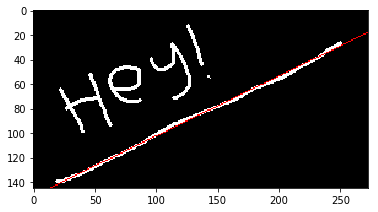

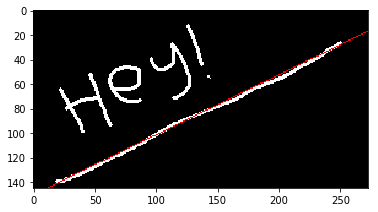

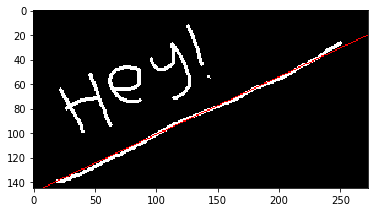

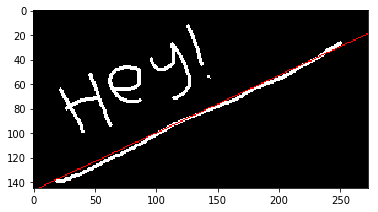

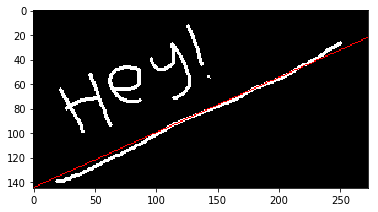

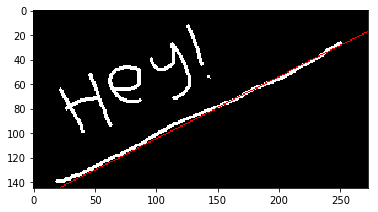

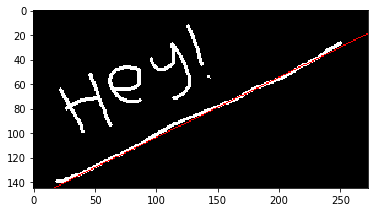

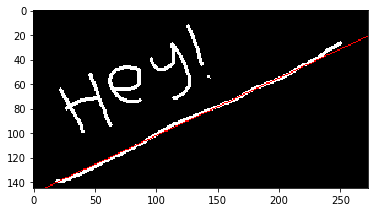

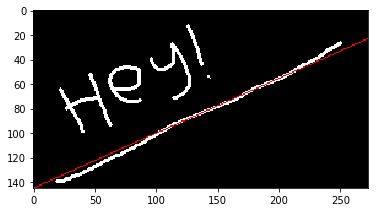

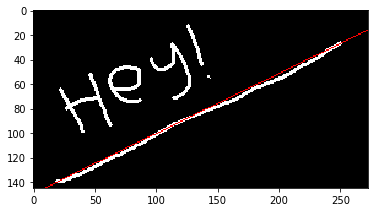

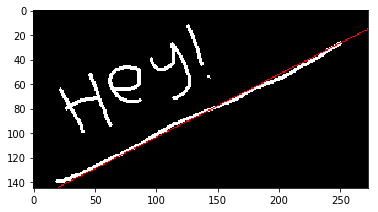

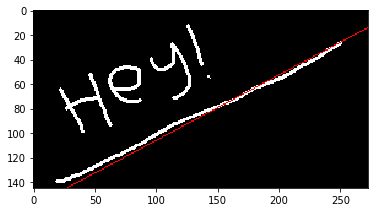

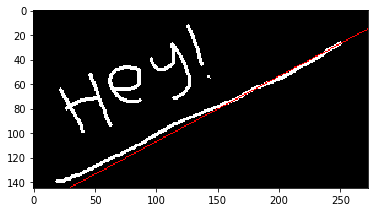

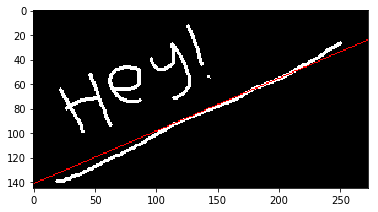

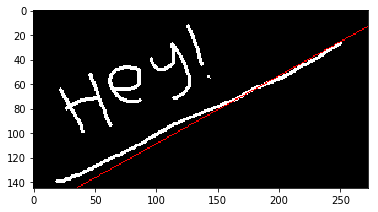

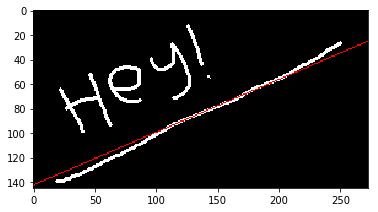

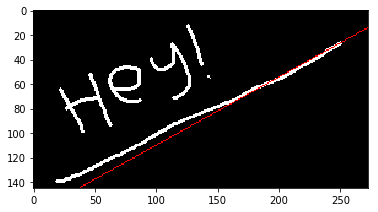

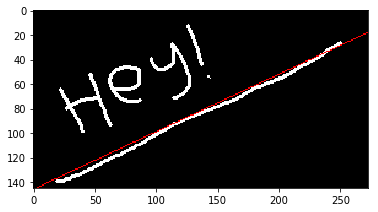

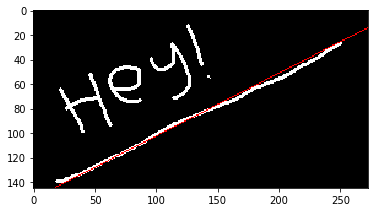

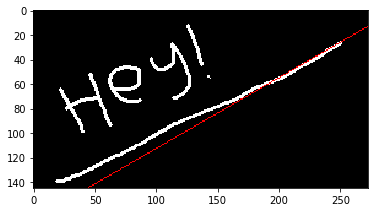

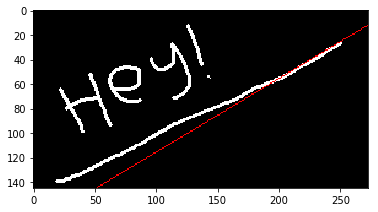

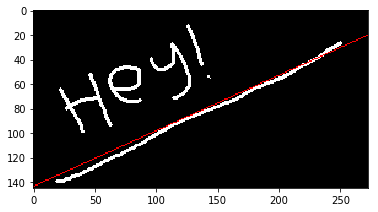

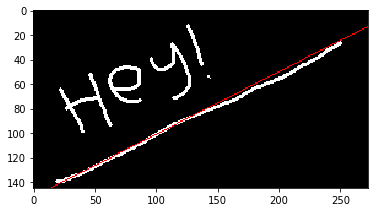

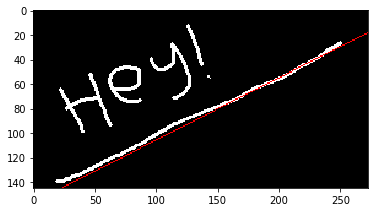

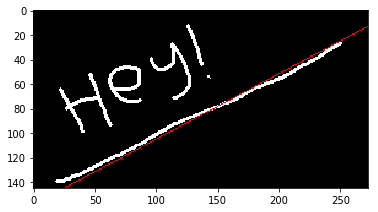

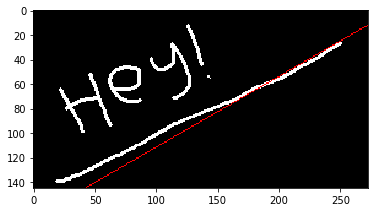

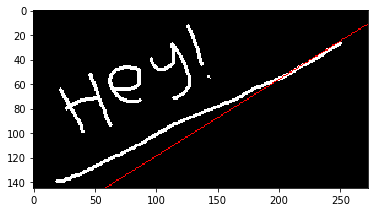

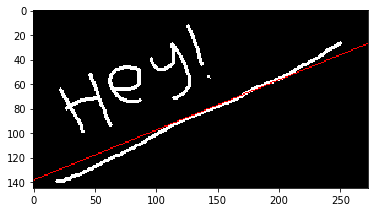

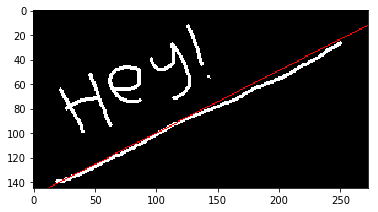

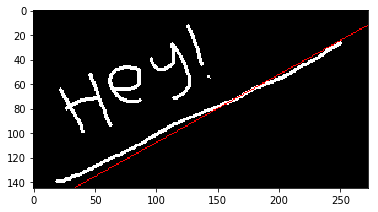

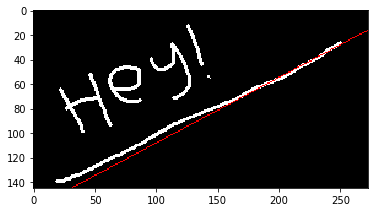

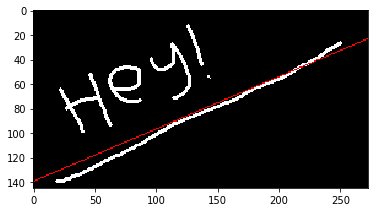

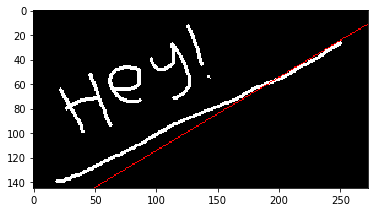

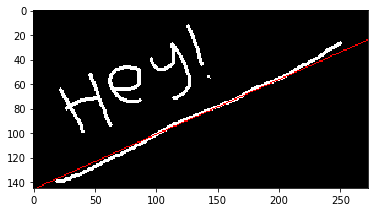

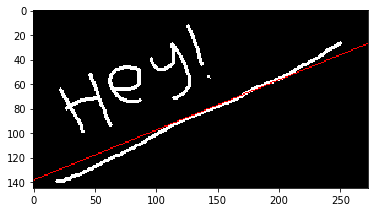

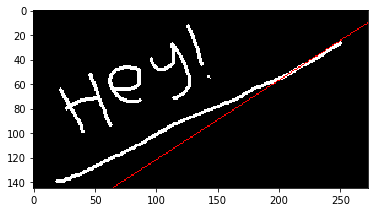

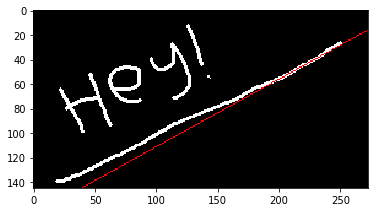

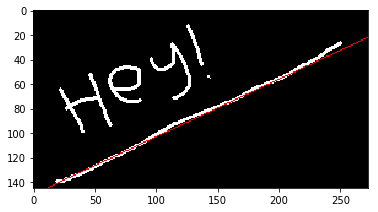

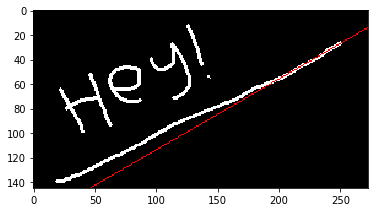

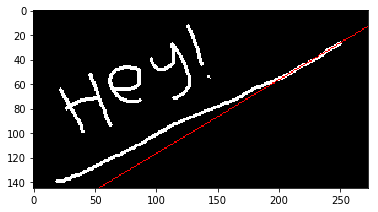

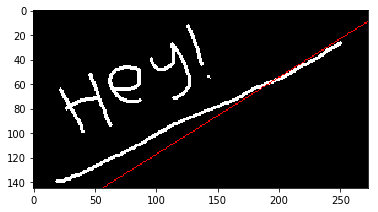

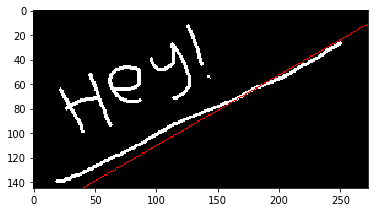

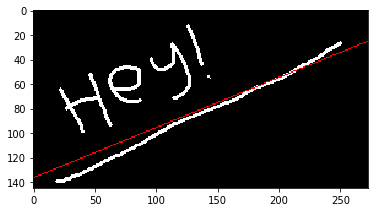

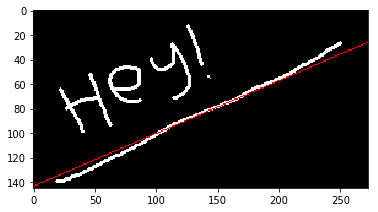

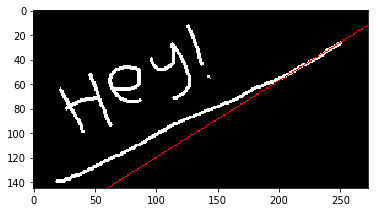

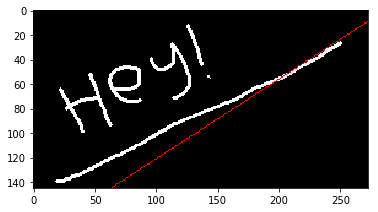

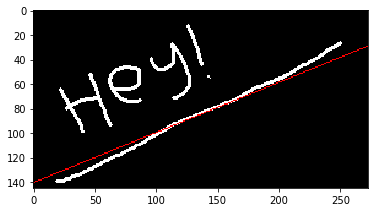

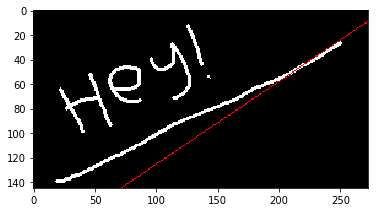

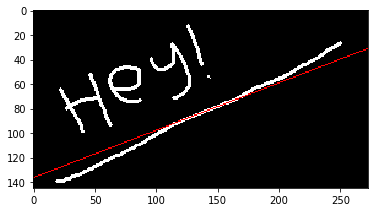

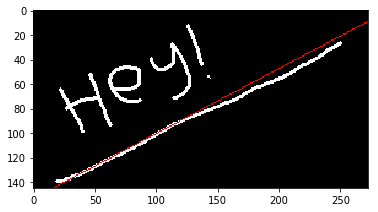

In [11]:
def draw_max(image, votes, color = (255,0,0), skip=False):
    rho0,theta0 = np.unravel_index(votes.argmax(), votes.shape)
    votes[rho0,theta0] = 0
    if skip:
        return
    
    rho = rho0*rho_step + rho_min
    theta = theta0*theta_step +theta_min
    if theta==0:
        theta+=0.5
    theta = np.deg2rad(theta)        
    
    x0 = 0
    y0 = int((rho-x0*np.cos(theta))/np.sin(theta))
    
    x1 = image.shape[0]
    y1 = int((rho-x1*np.cos(theta))/np.sin(theta))

    cv2.line(image, (y0,x0), (y1,x1),  color, 1)


image = votes.copy()
N = 50
for i in range(N):
    colored = cv2.cvtColor(bw*255, cv2.COLOR_GRAY2BGR)
    draw_max(colored, image, (255,0,0), False)
    plt.figure()
    plt.imshow(colored)

### Draw first N hough lines in 1 image

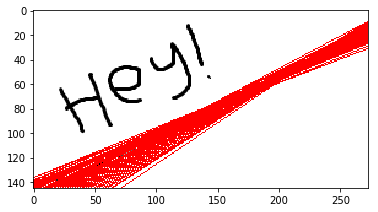

In [13]:
image = votes.copy()
im = img.copy()
N = 50
for i in range(N):
    draw_max(im, image, 255, False)

plt.figure()
plt.imshow(im)

### Apply Opencv's HoughLines functions

(1, 2)


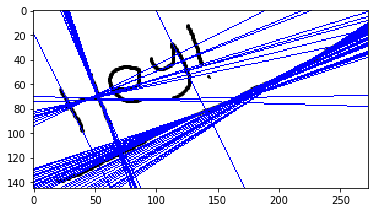

In [14]:
im = img.copy()

lines = cv2.HoughLines(bw, 1, np.pi/360, 0)
for i in range(50):
    for rho,theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(im,(x1,y1),(x2,y2),(0,0,255),1)

plt.imshow(im)
print(lines[0].shape)